# Haz del Telescopio, Ruido instrumental, y Filtrado

### Jeff McMahon y Renée Hložek. Traducción por Cristian Vargas

Ahora agregaremos ruido y filtraremos el mapa, de modo que tendremos un mapa más realista con efectos astrofísicos e instrumentales.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


#%cd /Tu/carpeta/con/mapas/y/librerias  ## Pon el directorio donde esten los mapas y las librerias

%matplotlib inline
import constantes as cs # modulo de constantes

from cmb_modulos import * # modulo de funciones
N = int(cs.N)
c_min = cs.c_min
c_max = cs.c_max
X_ancho =cs.X_ancho
Y_ancho = cs.Y_ancho  
tamaño_haz_fwhm = cs.tamaño_haz_fwhm # Anchura a media altura, abreviada FWHM (del inglés Full Width at Half Maximum)
tamaño_pix = cs.tamaño_pix
Numero_de_Fuentes  = cs.Numero_de_Fuentes
Amplitud_de_Fuentes = cs.Amplitud_de_Fuentes
Numero_de_Fuentes_EX = cs.Numero_de_Fuentes_EX
Amplitud_de_Fuentes_EX = cs.Amplitud_de_Fuentes_EX
Numero_de_Cumulos_SZ  = cs.Numero_de_Cumulos_SZ
Amplitud_promedio_de_cumulos_SZ = cs.Amplitud_promedio_de_cumulos_SZ
SZ_beta = cs.SZ_beta
SZ_Theta_central = cs.SZ_Theta_central

## Recalculando los resultados de las etapas anteriores

promedio del mapa: -24.913410342727833 , media cuadrática (rms) del mapa: 103.8864328288002


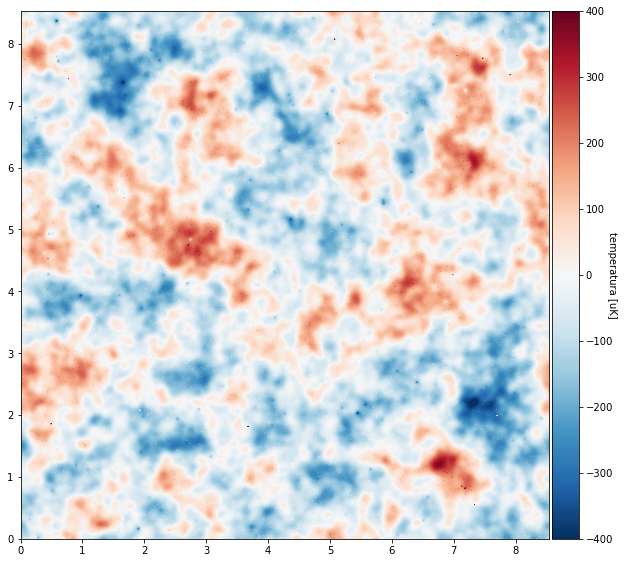

In [2]:
## Haciendo el mapa CMB

ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)

## Haciendo el mapa de fuentes puntuales
MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
MapaFP +=  componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)

## Haciendo el mapa de SZ
MapaSZ,catSZ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,\
                                  Amplitud_promedio_de_cumulos_SZ,SZ_beta,SZ_Theta_central,False)

## Agregando todo lo anterior para obtener un mapa del cielo a una frecuencia
mapa_total = CMB_T + MapaFP + MapaSZ

## Graficando el resultado
p=Graficar_Mapa_CMB(mapa_total,c_min,c_max,X_ancho,Y_ancho)

## Mapa del cielo convolucionado con el haz 

Los telescopios sufren de difracción lo que conduce a efectos de resolución finita (hay un límite de resolución del telescopio que depende del tamaño de este y la frecuencia a la que este observando). Para tomar en cuenta esto, generamos un patrón de haz gaussiano y convolucionamos el mapa con él.

promedio del mapa: -24.913410342727843 , media cuadrática (rms) del mapa: 102.39697699521639


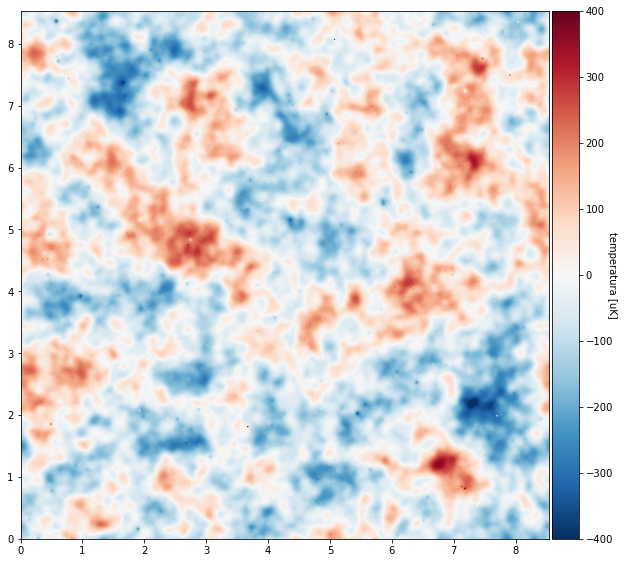

In [3]:
tamaño_haz_fwhm = 1.25 # FWHM del haz en arcominutos, aprox. la respuesta de un telescopio de 6 metros a 150 GHz

def mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,Mapa):
    """convoluciona un mapa con un patrón de haz gaussiano. 
    NOTA: tamaño_pix y tamaño_haz_fwhm deben estar en las mismas unidades"""

    # crea una Gaussiana 2D
    gaussiana = hacer_haz_gaussiano_2d(N,tamaño_pix,tamaño_haz_fwhm)
  
    # realiza la convolución
    TF_gaussiana = np.fft.fft2(np.fft.fftshift(gaussiana)) # primero usamos shift para que quede centrado
    TF_Mapa = np.fft.fft2(np.fft.fftshift(Mapa)) #shift en el mapa también
    mapa_convolucionado = np.fft.fftshift(np.real(np.fft.ifft2(TF_gaussiana*TF_Mapa)))
    
    # retorna el mapa convolucionado
    return(mapa_convolucionado)
  ###############################   


def hacer_haz_gaussiano_2d(N,tamaño_pix,tamaño_haz_fwhm):  
     # hacer el sistema de coordenadas 2d
    N=int(N)
    unos = np.ones(N)
    indices  = (np.arange(N)+.5 - N/2.) * tamaño_pix
    X = np.outer(unos,indices)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ##Para visualizar descomentar lo siguiente
    #plt.title('Coordenadas radiales')
    #plt.imshow(R)
  
    # hacer la gaussiana 2d
    sigma_haz = tamaño_haz_fwhm / np.sqrt(8.*np.log(2))
    gaussiana = np.exp(-.5 *(R/sigma_haz)**2.)
    gaussiana = gaussiana / np.sum(gaussiana)
    # retorna la gaussiana
    ##Para visualizar descomentar lo siguiente
    #plt.imshow(gaussian)
    return(gaussiana)
  ###############################  
    
    
## convolve the signal part of the map

CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,mapa_total)

p=Graficar_Mapa_CMB(CMB_T_convolucionado,c_min,c_max,X_ancho,Y_ancho)

Este gráfico muestra el mapa simulado que incluye las señales CMB, fuentes puntuales y SZ y está convolucionado con un haz instrumental. La concordancia con los mapas reales del cielo ahora es razonable, pero aún no incluye el ruido instrumental.

<font color='red'>EJERCICIO: </font> Hay tres tamaños de haz típicos para los experimentos CMB: 1) observatorios de modos B de gran escala angular que tienen haces de ~30 minutos de arco; 2) observatorios de mediana escala como el satélite Planck que tiene un haz de ~3 minutos de arco, y 3) observatorios de alta resolución como ACT y SPT que tienen haces de ~1 minuto de arco. Convoluciona el mapa con cada uno de estos casos y compare las diferencias.


In [4]:
## Tu codigo va aqui

comenta sobre las diferencias aqui

## Mapa de Ruido

Los observatorios de CMB que se encuentran en tierra sufren varios tipos de ruido. Esto incluye: (1) ruido blanco extraído de una distribución gaussiana; (2) el ruido atmosférico que crece en grandes escalas angulares, esto puede entenderse en términos de turbulencia de Kolmogorov; y (3) ruido $1/f$ en los detectores. Tanto el ruido atmosférico como el de detector $1/f$ se manifiestan como ruido correlacionado en el espacio de los mapas. Sin embargo, al igual que el CMB, estos componentes de ruido practicamente no están correlacionados en espacio de Fourier. Construiremos estos términos de ruido en el espacio de Fourier y los mostraremos en el espacio del mapa.

Elegiremos un nivel de ruido blanco de 10 $\mu$K-arcmin que se aproxima a los mapas profundos actuales de ACTPol y SPTPol. El ruido $1/f$ es similar a lo que se vería en un experimento en el polo sur. Cuando está activado, este ruido provoca un efecto de "rayas" en los mapas. De manera predeterminada, apagamos este componente, ya que si está incluido, necesitaríamos filtrar los mapas antes de estimar el espectro de potencia. (Esto es fácil, pero aún no está implementado). El ruido atmosférico (turbulencia de Kolmogorov) tiene un espectro 2D similar al CMB que conduce a patrones similares en los mapas.

promedio del mapa: 3.5811324764682753 , media cuadrática (rms) del mapa: 33.42917093315791


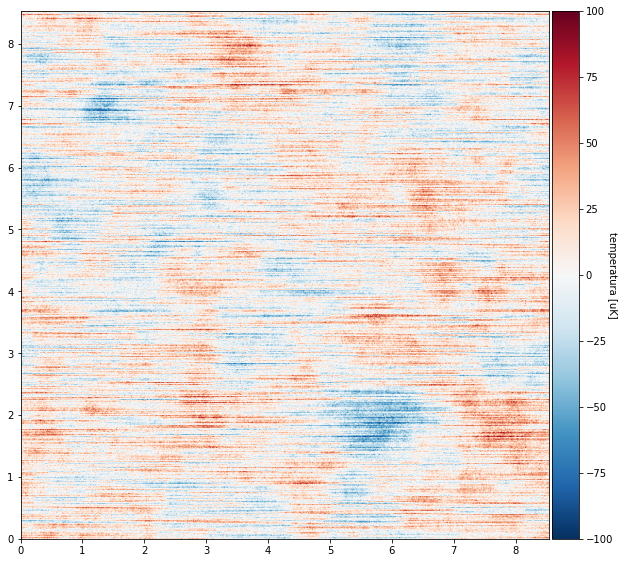

In [5]:
nivel_de_ruido_blanco = 10. 
nivel_de_ruido_atmosferico = 0.1  # multiplicar por cero para apagar esto
nivel_de_ruido_1sobref = 0.2 # multiplicar por cero para apagar esto

def hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref):
    "hace una realización de ruido instrumental, atmosférico y 1/f"
    
    ## hacer un mapa de ruido blanco
    ruido_blanco = np.random.normal(0,1,(N,N)) * nivel_de_ruido_blanco/tamaño_pix
 
    ## hacer un mapa de ruido atmosperico
    ruido_atmosferico = 0.
    if (nivel_de_ruido_atmosferico != 0):
        unos = np.ones(N)
        indices  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(unos,indices)
        Y = np.transpose(X)
        R = np.sqrt(X**2. + Y**2.) * tamaño_pix /60. ## angulos relativos a 1 grado
        mag_k = 2 * np.pi/(R+.01)  ## 0.01 es un factor de regularización
        ruido_atmosferico = np.fft.fft2(np.random.normal(0,1,(N,N)))
        ruido_atmosferico  = np.fft.ifft2(ruido_atmosferico * np.fft.fftshift(mag_k**(5/3.)))
        ruido_atmosferico = ruido_atmosferico * nivel_de_ruido_atmosferico/tamaño_pix

    ## hace un mapa 1/f, a lo largo de una sola dirección para ilustrar las bandas 
    ruido_1sobref = 0.
    if (nivel_de_ruido_1sobref != 0): 
        unos = np.ones(N)
        indices  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(unos,indices) * tamaño_pix /60. ## angulos relativos a 1 grado
        kx = 2 * np.pi/(X+.01) ## 0.01 es un factor de regularización
        ruido_1sobref = np.fft.fft2(np.random.normal(0,1,(N,N)))
        ruido_1sobref = np.fft.ifft2(ruido_1sobref * np.fft.fftshift(kx))* nivel_de_ruido_1sobref/tamaño_pix

    ## retorna el mapa de ruido
    mapa_ruido = np.real(ruido_blanco + ruido_atmosferico + ruido_1sobref)
    return(mapa_ruido)
  ###############################


## hace un mapa de ruido instrumental
Ruido = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)

p=Graficar_Mapa_CMB(Ruido,c_min/4.,c_max/4.,X_ancho,Y_ancho)

Este grafico muestra una realización de ruido instrumental + atmosférico. El ruido atmosférico se parece al CMB ya que tiene un espectro 2d similar.

<font color='red'>EJERCICIO: </font>  La simulación anterior tiene ruido atmosférico y de detector $1/f$. Para comprender estos componentes por separado, apaga cada uno y haz gráficos de cada uno de los componentes por separado. Comenta cómo se ven estos.

Grafica el valor absoluto de la transformada de fourier 2d de estos mapas y observa cómo se localiza el componente no blanco del ruido.

NOTA: Este mapa asume que no hay cross-linking, el ruido $1/f$ se vería diferente si hubiera dos o más direcciones de escaneo en el mapa. (Es decir es como si el telescopio se estuviese moviendo en una sola dirección)


In [6]:
## tu codigo y graficos van aqui

Tus comentarios van aqui.

## Filtrado

En mapas con ruido dependiente de la frecuencia, a menudo es ventajoso filtrar los mapas para 'blanquear' el espectro de ruido. Hay una amplia variedad de opciones de qué hacer aquí. Tanto para el ruido atmosférico como para el de $1/f$, un filtro paso alto sería una opción eficaz. Esto podría ser un filtro cuadrado (donde los modos debajo de un límite se establecen en cero mientras que los modos de longitud de onda más corta se mantienen sin cambios) o un filtro que pondera los modos de Fourier por $1/A$ donde $A$ es la amplitud de la distribución de ruido. A continuación se muestra el código que enmascara los modos de fourier $N_{mascara}$ a lo largo de la dirección de exploración. Ve el ejercicio a continuación y juegue con él.


promedio del mapa: 5.204170427930421e-18 , media cuadrática (rms) del mapa: 20.931510034898626


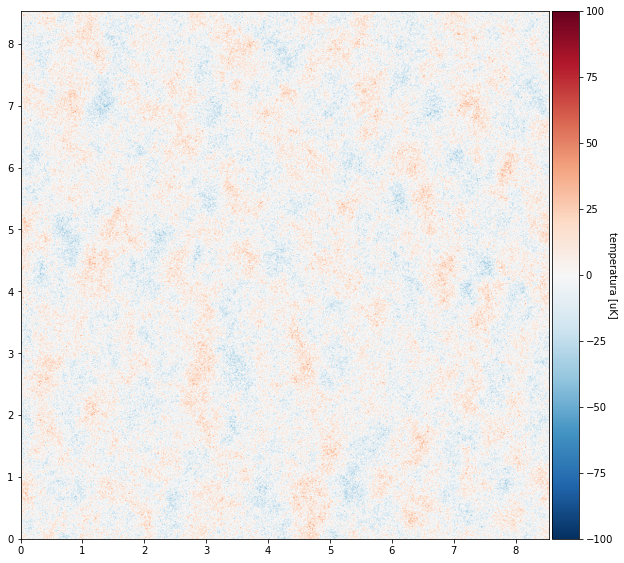

In [7]:
N_mascara = 4

def Mapa_Filtrado(Mapa,N,N_mascara):
    ## configurar las coordenadas x, y, r para la generación de máscaras
    unos = np.ones(N) # N es el tamaño del mapa
    indices  = (np.arange(N)+.5 - N/2.) 

    X = np.outer(unos,indices)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)  ## angulos relativos a 1 grado
    
    ## crea la mascara
    mascara = np.ones([N,N])
    mascara[np.where(np.abs(X) < N_mascara)]  = 0
    
    ## aplica el filtro en espacio de Fourier
    MapaF = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Mapa)))
    MapaF_filtrado = MapaF * mascara
    Mapa_filtrado = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(MapaF_filtrado))))
    
    ## retorna el mapa filtrado
    return(Mapa_filtrado)


filtrado = Mapa_Filtrado(Ruido,N,N_mascara)
p=Graficar_Mapa_CMB(filtrado,c_min/4.,c_max/4.,X_ancho,Y_ancho)

<font color='red'>EJERCICIO: </font> Encuentra el $N_{mascara}$ mínimo que efectivamente blanquea el espectro de ruido con el mal $1/f$ activado. Ve cómo funciona este filtro para el ruido atmosférico. Comenta si este filtro funciona y si es una buena opción para el ruido atmosférico.

In [8]:
## tu codigo va aqui

tus comentarios van aqui

## Simulación completa de un mapa CMB

Completamos nuestro mapa CMB simulado agregando el mapa del cielo simulado convolucionado con el haz a nuestro mapa de ruido simulado.

promedio del mapa: -21.33227786625955 , media cuadrática (rms) del mapa: 107.49493659060252


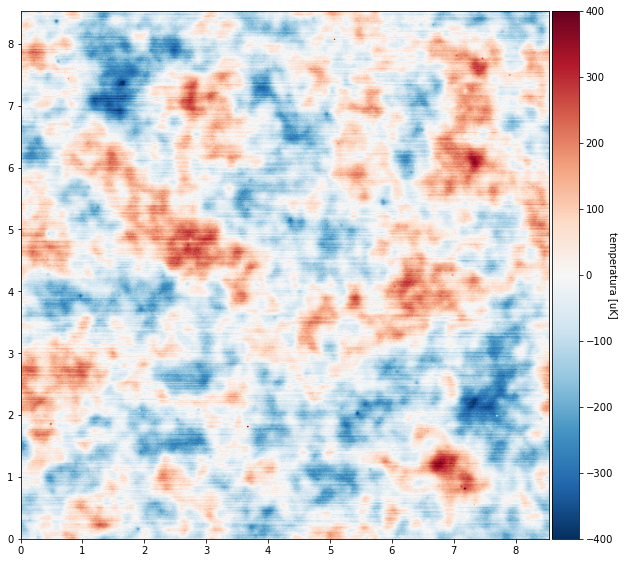

In [9]:
CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,mapa_total)

mapa_total_mas_ruido = CMB_T_convolucionado + Ruido

p=Graficar_Mapa_CMB(mapa_total_mas_ruido,c_min,c_max,X_ancho,Y_ancho)

Este gráfico muestra un mapa CMB simulado completo que incluye los efectos astrofísicos e instrumentales claves.